# Script for scCODA analysis
## Description:
This script takes as input the table of total count of cells for each cell type per bat individual. scCODA analysis is then performed to determine with cell types are differentially abundant across ages. All pair-wise tests are performed (Adu vs Juv, Juv vs Adu, Adu vs Sub...). Only significant differences with FDR < 0.05 or 0.1 were further considered.

In [1]:
# Setup python packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

# Load data from input table

In [2]:
# Load data
cell_counts = pd.read_csv("../outputs/scCODA/Input_table_scCODA.csv")
print(cell_counts)

  Individual       Age  Neutrophils  Eosinophils  CD16 Monocytes  \
0       Adu1     Adult          366          119              60   
1       Adu2     Adult          708           66              70   
2       Adu3     Adult         1067           91              33   
3       Adu4     Adult           92           33              69   
4       Sub1  Subadult          279          148             135   
5       Sub2  Subadult          108           50             125   
6       Juv1  Juvenile          240          267              83   
7       Juv2  Juvenile          478          141              32   
8       Juv3  Juvenile           47           70              18   

   CD14 Monocytes  cDC2  cDC1  pDC  NKT-like 2  ...  CD4 CM1  CD4 CM2  Treg  \
0              63    40     8    8          27  ...       81       46    52   
1              63    20     5    4          24  ...       41       19    43   
2              67    28     4    6          17  ...       48       13    24   
3  

In [3]:
# Convert data to anndata object
data_all = dat.from_pandas(cell_counts, covariate_columns=["Age", "Individual"])
print(data_all)

AnnData object with n_obs × n_vars = 9 × 22
    obs: 'Age', 'Individual'


<AxesSubplot:xlabel='Cell type', ylabel='Proportion'>

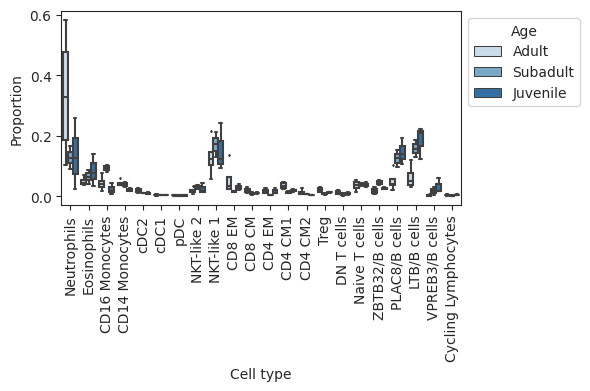

In [4]:
# Boxplot 
viz.boxplots(data_all, feature_name="Age")

<AxesSubplot:title={'center':'Individual'}, ylabel='Proportion'>

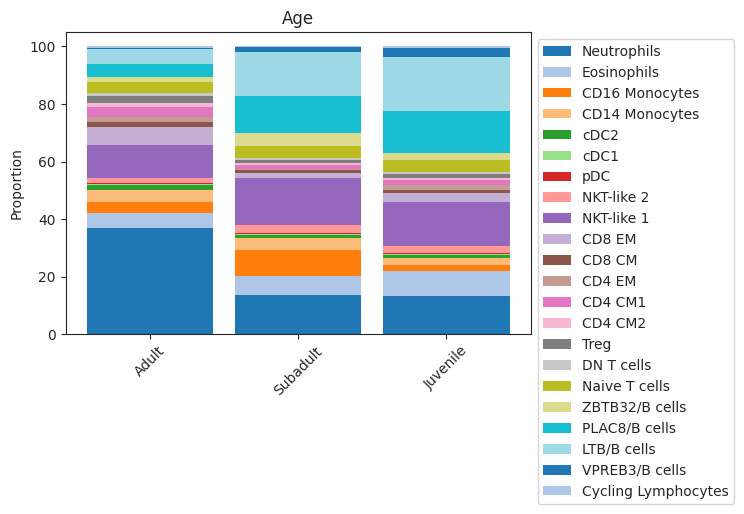

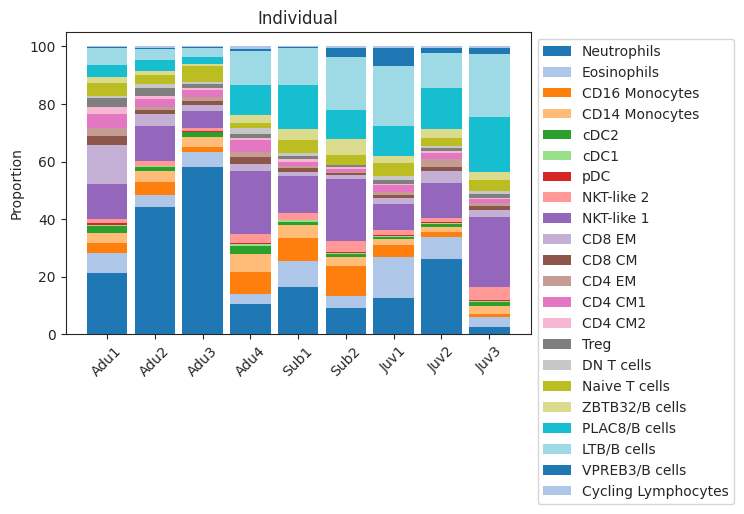

In [5]:
# Stacked barplot per Age
viz.stacked_barplot(data_all, feature_name="Age")


# Stacked barplot per Individual
viz.stacked_barplot(data_all, feature_name="Individual")

# Build scCODA Model with Adult individuals as default

In [8]:
# Model setup and inference
model_age_Adu = mod.CompositionalAnalysis(data_all,
                                          formula="C(Age, Treatment('Adult'))",
                                          reference_cell_type="automatic")

# Run MCMC
sim_results_Adu = model_age_Adu.sample_hmc(num_results=50000, num_burnin=10000)

Automatic reference selection! Reference cell type set to cDC1


100%|██████████| 50000/50000 [09:59<00:00, 83.39it/s] 


MCMC sampling finished. (727.055 sec)
Acceptance rate: 45.0%


# Build scCODA Model with Subadult individuals as default

In [12]:
# Model setup and inference
model_age_Sub = mod.CompositionalAnalysis(data_all,
                                          formula="C(Age, Treatment('Subadult'))",
                                          reference_cell_type="automatic")

# Run MCMC
sim_results_Sub = model_age_Sub.sample_hmc(num_results=50000, num_burnin=10000)

Automatic reference selection! Reference cell type set to cDC1


100%|██████████| 50000/50000 [10:48<00:00, 77.13it/s] 


MCMC sampling finished. (774.822 sec)
Acceptance rate: 53.9%


# Build scCODA Model with Juvenile individuals as default

In [13]:
# Model setup and inference
model_age_Juv = mod.CompositionalAnalysis(data_all,
                                          formula="C(Age, Treatment('Juvenile'))", 
                                          reference_cell_type="automatic")

# Run MCMC
sim_results_Juv = model_age_Juv.sample_hmc(num_results=50000, num_burnin=10000)

Automatic reference selection! Reference cell type set to cDC1


100%|██████████| 50000/50000 [10:09<00:00, 82.03it/s] 


MCMC sampling finished. (727.207 sec)
Acceptance rate: 66.2%


# Save and load results

In [14]:
#Save scCODA results
sim_results_Adu.save("../outputs/scCODA/results_Adu")
sim_results_Sub.save("../outputs/scCODA/results_Sub")
sim_results_Juv.save("../outputs/scCODA/results_Juv")

#Check these files with the code below to determine significant differences

In [19]:
#Load saved results
path = "../outputs/scCODA/results_Juv"
chosen_fdr = 0.1 #Should check results with FDR 0.05 and 0.1

with open(path, "rb") as f:
    sim_results_loaded = pkl.load(f)
    
sim_results_loaded.set_fdr(est_fdr= chosen_fdr) #select FDR for loaded data
print(sim_results_loaded.credible_effects()) #display credible results

Covariate                                  Cell Type          
C(Age, Treatment('Juvenile'))[T.Adult]     Neutrophils             True
                                           Eosinophils            False
                                           CD16 Monocytes         False
                                           CD14 Monocytes         False
                                           cDC2                   False
                                           cDC1                   False
                                           pDC                    False
                                           NKT-like 2             False
                                           NKT-like 1             False
                                           CD8 EM                 False
                                           CD8 CM                 False
                                           CD4 EM                 False
                                           CD4 CM1                False
 

###

In [ ]:
# Explore Output
sim_results_loaded.summary()

In [ ]:
# Explore extended output
sim_results_loaded.summary_extended(hdi_prob=0.9)